In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from tensorflow_gan.python.losses.losses_impl import wasserstein_generator_loss, wasserstein_discriminator_loss

In [2]:
df = pd.read_csv("data/metadata.csv")

In [3]:
df

,card_file_name,id,link,name,rarity,setname,type
0,data/pictures/Base Set/Alakazam_(Base_Set_1),1/102,https://bulbapedia.bulbagarden.net/wiki/Alakaz...,Alakazam,Rare Holo,Base Set,Psychic
1,data/pictures/Base Set/Blastoise_(Base_Set_2),2/102,https://bulbapedia.bulbagarden.net/wiki/Blasto...,Blastoise,Rare Holo,Base Set,Water
2,data/pictures/Base Set/Chansey_(Base_Set_3),3/102,https://bulbapedia.bulbagarden.net/wiki/Chanse...,Chansey,Rare Holo,Base Set,Colorless
3,data/pictures/Base Set/Charizard_(Base_Set_4),4/102,https://bulbapedia.bulbagarden.net/wiki/Chariz...,Charizard,Rare Holo,Base Set,Fire
4,data/pictures/Base Set/Clefairy_(Base_Set_5),5/102,https://bulbapedia.bulbagarden.net/wiki/Clefai...,Clefairy,Rare Holo,Base Set,Colorless
...,...,...,...,...,...,...,...
9937,data/pictures/Pokémon Rumble/Lucario_(Pok%C3%A...,12/16,https://bulbapedia.bulbagarden.net/wiki/Lucari...,Lucario,Unknown rarity,Pokémon Rumble,Fighting
9938,data/pictures/Pokémon Rumble/Skuntank_(Pok%C3%...,13/16,https://bulbapedia.bulbagarden.net/wiki/Skunta...,Skuntank,Unknown rarity,Pokémon Rumble,Darkness
9939,data/pictures/Pokémon Rumble/Bastiodon_(Pok%C3...,14/16,https://bulbapedia.bulbagarden.net/wiki/Bastio...,Bastiodon,Unknown rarity,Pokémon Rumble,Metal
9940,data/pictures/Pokémon Rumble/Rattata_(Pok%C3%A...,15/16,https://bulbapedia.bulbagarden.net/wiki/Rattat...,Rattata,Unknown rarity,Pokémon Rumble,Colorless


# Drop a couple of bad records

In [4]:
df = df[~df["card_file_name"].isin([
    "data/pictures/Mysterious Treasures/Honchkrow_(Mysterious_Treasures_10)",
    "data/pictures/Unified Minds/Umbreon_%26_Darkrai-GX_(Unified_Minds_125)", # missing on website
    "data/pictures/Base Set/Charizard_(Base_Set_4)", # special version of normal website
    "data/pictures/Stormfront/Charizard_(Stormfront_103)", # special version of normal website
])]

filter to Pokemon types

In [5]:
# df.type.value_counts()
filter_to_pokemon_types = False
filter_to_simple_rarities = True

if filter_to_pokemon_types:
    df = df[df["type"].isin([
        "Water",
        "Grass",
        "Colorless",
        "Psychic",
        "Fighting",
        "Fire",
        "Lightning",
        "Darkness",
        "Metal",
        "Dragon",
        "Fairy",
    ])]

if filter_to_simple_rarities:
    df = df[df["rarity"].isin([
        "Common",
        "Uncommon",
        "Rare",
        "Rare Holo",
        "Rare Holo ex",
    ])]


# Parameters

In [69]:
n_epochs = 200
n_random_inputs_per_training = 800
n_real_per_training = 4000
batch_size = 100

n_generator_input = 100
n_generator_dense = 200

use_greyscale = False

columns_as_input = [
    "rarity",
    "type",
#     "setname"
]

# Create dataset

In [7]:
# Function to load and preprocess each image
def parse_image_file(
    filename,
    label = None,
    crop=False,
    to_greyscale=False,
):
    img = tf.io.read_file(filename)
    img = tf.cast(tf.image.decode_jpeg(img, channels=3), tf.float32) / 255.0
    
#     if img.shape[0] < 50:
#         print(f"Error with image `{filename}`: shape found was small: {img.shape}")
    img = tf.image.resize_with_crop_or_pad(img, 260, 180)
    
    # Some images have an extra alpha channel. Remove that.
    img = img[:, :, :3]
    
    if crop:
        img = tf.image.crop_to_bounding_box(
            img, 
            offset_height = 35,
            offset_width = 20,
            target_height = 100,
            target_width = 140,
        )
        
    if to_greyscale:
        img = tf.image.rgb_to_grayscale(img)
        img = tf.expand_dims(img, -1)
    
    if label is None: return img
    else: return img, label

In [8]:
n_records = df.shape[0]

In [9]:
images = tf.constant(df["card_file_name"].values)
x = tf.stack([parse_image_file(img, crop=True, to_greyscale=use_greyscale) for img in images], axis=0)
gc.collect()

16

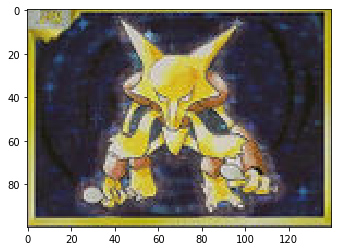

In [10]:
example_input = x[0]
generator_dense_output_size = int(tf.reduce_prod(example_input.shape))
generator_output_size = example_input.shape

plt.imshow(tf.squeeze(x[0]), cmap='gray')

### Make the class dataset

In [11]:
def label_converter(label):
    return tf.math.argmax(label, axis=-1)

def make_conversion_function(classes):
    return lambda idx: convert_column(idx, classes)

def convert_column(idx, classes):
    return tf.gather(classes, idx)
    
def target_columns_to_tf(column_names):
    y = {}
    size_per_class = []
    conversion_functions = {}
    
    for colname in column_names:
        col = df[colname]
        classnames, indices = np.unique(col.values, return_inverse=True)
        classnames = np.append(classnames, "Fake")
        n_classes = len(classnames)
        size_per_class.append(n_classes)
        
        conversion_functions[colname] = make_conversion_function(classnames)
        y[colname] = keras.utils.to_categorical(indices, n_classes)

    return (
        y,
        size_per_class,
        conversion_functions,
    )

In [12]:
y, size_per_class, conversion_functions = target_columns_to_tf(columns_as_input)

def convert_target_matrix_to_label(pred, colname):
    current_start_index = 0
    pred = pred[colname]
    
    label_indices = label_converter(pred)
    return conversion_functions[colname](label_indices)


In [13]:
convert_target_matrix_to_label(y, "type")

<tf.Tensor: shape=(8711,), dtype=string, numpy=
array([b'Psychic', b'Water', b'Colorless', ..., b'T', b'T [Su]',
       b'Colorless'], dtype=object)>

# Generator

In [150]:
generator_conv_sizes = [9, 3, 1]
generator_init_height = generator_output_size[0]
generator_init_width = generator_output_size[1]
generator_init_channels = 40
generator_filters = 10

for conv_size in reversed(generator_conv_sizes):
    print(f"{conv_size} --- width: {generator_init_width}\t height: {generator_init_height}")
    generator_init_width = (generator_init_width - (conv_size - 1)) / 2
    generator_init_height = (generator_init_height - (conv_size - 1)) / 2
    
assert int(generator_init_width) == generator_init_width and int(generator_init_height) == generator_init_height
generator_init_width = int(generator_init_width)
generator_init_height = int(generator_init_height)

generator_last_dense_layer = generator_init_height * generator_init_channels * generator_init_width

1 --- width: 140	 height: 100
3 --- width: 70.0	 height: 50.0
9 --- width: 34.0	 height: 24.0


In [151]:
generator_input = keras.layers.Input((n_generator_input + sum(size_per_class),))
gen_x = keras.layers.Dropout(.5)(generator_input)
gen_x = keras.layers.Dense(n_generator_dense)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Dense(n_generator_dense)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Dense(generator_last_dense_layer)(gen_x)
gen_x = keras.layers.LeakyReLU()(gen_x)
gen_x = keras.layers.Reshape((generator_init_height, generator_init_width, generator_init_channels))(gen_x)


for i, conv_size in enumerate(generator_conv_sizes):
    if i < len(generator_conv_sizes) - 1:
        act = "relu"
        filters=generator_filters
    else:
        act = "sigmoid"
        filters= 1 if use_greyscale else 3
    
    
    gen_x = keras.layers.UpSampling2D(size=2)(gen_x)
    gen_x = keras.layers.Conv2DTranspose(
        filters=filters, 
        kernel_size=conv_size,
        activation=act,
    )(gen_x)
    
generator = keras.Model(generator_input, gen_x)

In [152]:
generator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 126)]             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 126)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               25400     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4160)              8361

In [153]:
random_input = tf.expand_dims(
    tf.ones(n_generator_input + sum(size_per_class)), 0
)
assert generator.predict(random_input).shape == tf.expand_dims(example_input, 0).shape

# Discriminator

In [20]:
inputs = keras.layers.Input(shape=generator_output_size)
x_1 = keras.layers.Dropout(.5, input_shape=generator_output_size)(inputs)
x_1 = keras.layers.Conv2D(filters=60, kernel_size=5, strides=2, input_shape=generator_output_size)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Conv2D(filters=20, kernel_size=5, strides=2)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Flatten()(x_1)
x_1 = keras.layers.Dense(units=200)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
x_1 = keras.layers.Dense(units=200)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
    
outputs = {
    colname: keras.layers.Dense(units=size, activation="softmax", name=colname)(x_1) 
    for colname, size in zip(columns_as_input, size_per_class)
}


discriminator = keras.Model(inputs, outputs, name="discriminator")

In [28]:
inputs = keras.layers.Input(shape=generator_output_size)
x_1 = keras.layers.Dropout(.5, input_shape=generator_output_size)(inputs)
x_1 = keras.layers.Conv2D(filters=60, kernel_size=5, strides=2, input_shape=generator_output_size)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Conv2D(filters=20, kernel_size=5, strides=2)(x_1)
x_1 = keras.layers.MaxPool2D()(x_1)
x_1 = keras.layers.Flatten()(x_1)
x_1 = keras.layers.Dense(units=200)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
x_1 = keras.layers.Dense(units=200)(x_1)
x_1 = keras.layers.LeakyReLU()(x_1)
    
outputs = {
    colname: keras.layers.Dense(units=size, activation="softmax", name=colname)(x_1) 
    for colname, size in zip(columns_as_input, size_per_class)
}


discriminator = keras.Model(inputs, outputs, name="discriminator")

discriminator.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.CategoricalAccuracy()],
)
discriminator.trainable = False

In [29]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 140, 3) 0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100, 140, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 68, 60)   4560        dropout_2[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 24, 34, 60)   0           conv2d_2[0][0]                   
______________________________________________________________________________________

# Generator training model

In [154]:
generator_trainer = keras.Model(
    generator_input,
    discriminator(generator(generator_input)), 
)

generator_trainer.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 126)]             0         
_________________________________________________________________
model_4 (Model)              (None, 100, 140, 3)       935113    
_________________________________________________________________
discriminator (Model)        {'rarity': (None, 6), 'ty 220206    
Total params: 1,155,319
Trainable params: 935,113
Non-trainable params: 220,206
_________________________________________________________________


In [155]:
def generator_loss(y_true, y_pred):
    return tf.reduce_mean(-tf.math.log(y_pred + 1.0e-6))

In [156]:
generator_trainer.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=.001),
#     loss=generator_loss,
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.CategoricalAccuracy()],
)

In [157]:
random_input = tf.expand_dims(
    tf.ones(n_generator_input+sum(size_per_class)), 0
)
test_predict = generator_trainer.predict(random_input)

for output, expected_size in zip(test_predict, size_per_class):
    assert output.shape[1] == expected_size, f"{output.shape} vs {expected_size}"

# Training

In [99]:
def make_generator_input(n_records):
    base_random_input = tf.random.normal((n_records, n_generator_input))
    
    labels = [
        keras.utils.to_categorical(
            tf.convert_to_tensor(
                np.random.randint(size=(n_records, 1), low=0, high=size-1) # -1 to avoid making fake classes
            )
        , size)
        for size in size_per_class
    ]
    
    x_extra = tf.concat(labels, axis=-1)
    
    x = tf.concat([base_random_input, x_extra], axis=-1)
    y = {colname: label for colname, label in zip(columns_as_input, labels)}
    return x, y

assert make_generator_input(10)[0].shape[1] == n_generator_input + sum(size_per_class)

In [35]:
# Intionally swapped tradidtion fake/real labels
def make_fake_label(n_records):
    return {
        colname: keras.utils.to_categorical(tf.ones((n_records, 1)) * (size - 1), size)
        for colname, size in zip(columns_as_input, size_per_class)
    }

def make_real_label(n_records):
    return make_label(n_records, 0.9, 1)

def make_label(n_records, min_, max_):
    return tf.random.uniform(shape=(n_records, 1), minval=min_, maxval=max_)

def concat_y(y_1, y_2):
    return {k: tf.concat((v, y_2[k]), axis=0) for k, v in y_1.items()}

def squeeze_y(Y, idx):
    return {k: tf.squeeze(tf.gather(v, idx)) for k, v in Y.items()}

# Pretrain discriminator

In [36]:
def train_discriminator(
    epochs,
    n_real=n_real_per_training,
    n_fake=n_random_inputs_per_training,
    
):
    with_real = n_real > 0
    with_fake = n_fake > 0 
    
    if with_fake:
        generator_x, generator_y = make_generator_input(n_fake)
        generated_input = generator.predict(generator_x)
        generator_y_fake = make_fake_label(n_fake)

    if with_real:
        if n_real == x.shape[0]:
            real_x = x
            real_y = y
        else:
            real_indices = np.random.randint(size=(n_real, 1), low=0, high=n_records)
            real_x = tf.squeeze(tf.gather(x, real_indices))
            real_y = squeeze_y(y, real_indices)
    
    if with_real and with_fake:
        discriminator_x = tf.concat((real_x, generated_input), axis=0)
        discriminator_y = concat_y(real_y, generator_y_fake)
    elif with_real:
        discriminator_x = real_x
        discriminator_y = real_y
    elif with_fake:
        discriminator_x = generated_input
        discriminator_y = generator_y_fake
        
    discriminator.fit(discriminator_x, discriminator_y, epochs=epochs, shuffle=True, batch_size=batch_size)

In [43]:
try:
    train_discriminator(epochs=30, n_real=x.shape[0], n_fake=0)
finally:
    gc.collect()

Train on 8711 samples
Epoch 1/20
8711/8711 [==============================] - 15s 2ms/sample - loss: 1.6915 - rarity_loss: 0.7872 - type_loss: 0.9044 - rarity_categorical_accuracy: 0.6874 - type_categorical_accuracy: 0.6913
Epoch 2/20
8711/8711 [==============================] - 15s 2ms/sample - loss: 1.6269 - rarity_loss: 0.7551 - type_loss: 0.8658 - rarity_categorical_accuracy: 0.6951 - type_categorical_accuracy: 0.6988
Epoch 3/20
8711/8711 [==============================] - 15s 2ms/sample - loss: 1.5185 - rarity_loss: 0.7261 - type_loss: 0.7905 - rarity_categorical_accuracy: 0.7057 - type_categorical_accuracy: 0.7346
Epoch 4/20
8711/8711 [==============================] - 15s 2ms/sample - loss: 1.4502 - rarity_loss: 0.6915 - type_loss: 0.7556 - rarity_categorical_accuracy: 0.7268 - type_categorical_accuracy: 0.7349
Epoch 5/20
8711/8711 [==============================] - 15s 2ms/sample - loss: 1.3690 - rarity_loss: 0.6707 - type_loss: 0.6983 - rarity_categorical_accuracy: 0.7333 - ty

KeyboardInterrupt: 

# Train generator

In [38]:
def train_generator(
    epochs: int,
    n_fake = n_random_inputs_per_training,
):
    generator_x, generator_y = make_generator_input(n_fake)
    
    # stupid renaming because of keras bullshit.
    make_name = lambda i: "discriminator" if i==0 else f"discriminator_{i}"
    generator_y_gen = {make_name(i): generator_y[col] for i, col in enumerate(columns_as_input)}
    
    generator_trainer.fit(generator_x, generator_y_gen, epochs=epochs, batch_size=batch_size)

In [190]:
gc.collect()
try:
    for i in range(n_epochs):
        print(f"{i} / {n_epochs}")

        # discriminator
        train_discriminator(2, n_fake=n_random_inputs_per_training, n_real=n_real_per_training)
        gc.collect()
        
        # generator
        train_generator(1, n_fake=n_random_inputs_per_training)
        gc.collect()
finally:
    gc.collect()

0 / 200
Train on 4800 samples
Epoch 1/2
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.4015 - rarity_loss: 0.2108 - type_loss: 0.1907 - rarity_categorical_accuracy: 0.9321 - type_categorical_accuracy: 0.9388
Epoch 2/2
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.2202 - rarity_loss: 0.1314 - type_loss: 0.0888 - rarity_categorical_accuracy: 0.9560 - type_categorical_accuracy: 0.9715
Train on 800 samples
800/800 [==============================] - 3s 4ms/sample - loss: 6.2600 - discriminator_loss: 2.8485 - discriminator_1_loss: 3.4115 - discriminator_categorical_accuracy: 0.4688 - discriminator_1_categorical_accuracy: 0.3850
1 / 200
Train on 4800 samples
Epoch 1/2
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.4522 - rarity_loss: 0.2451 - type_loss: 0.2070 - rarity_categorical_accuracy: 0.9217 - type_categorical_accuracy: 0.9375
Epoch 2/2
4800/4800 [==============================] - 8s 2ms/sample - loss: 0.2460 - rarity_lo

KeyboardInterrupt: 

In [176]:
gc.collect()

20

# Test a couple of records

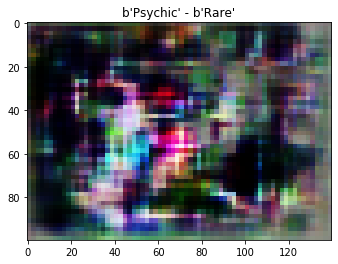

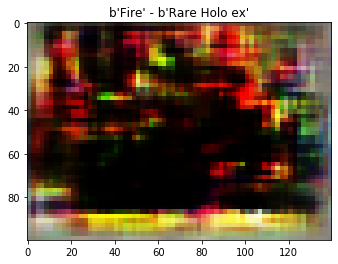

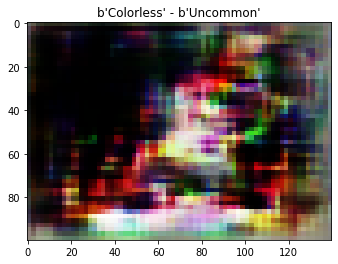

In [199]:
def plot_images_and_classes(n):
    inputs, y = make_generator_input(n)
    predictions = generator.predict(inputs)
    labels = {k: convert_target_matrix_to_label(y, k) for k in y}
    
    for i in range(n):
        img = predictions[i]        
        plt.imshow(img)
        plt.title(f"{labels['type'][i]} - {labels['rarity'][i]}")
        plt.show()

plot_images_and_classes(3)

In [162]:
try:
    train_generator(10, 2000)
finally:
    gc.collect()

Train on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 8s 4ms/sample - loss: 3.3867 - discriminator_loss: 1.1152 - discriminator_1_loss: 2.2715 - discriminator_categorical_accuracy: 0.5790 - discriminator_1_categorical_accuracy: 0.4590
Epoch 2/10
2000/2000 [==============================] - 8s 4ms/sample - loss: 3.0978 - discriminator_loss: 1.0344 - discriminator_1_loss: 2.0634 - discriminator_categorical_accuracy: 0.6075 - discriminator_1_categorical_accuracy: 0.5100
Epoch 3/10
2000/2000 [==============================] - 8s 4ms/sample - loss: 2.9603 - discriminator_loss: 1.0248 - discriminator_1_loss: 1.9356 - discriminator_categorical_accuracy: 0.6010 - discriminator_1_categorical_accuracy: 0.5170
Epoch 4/10
2000/2000 [==============================] - 8s 4ms/sample - loss: 2.8707 - discriminator_loss: 0.9889 - discriminator_1_loss: 1.8818 - discriminator_categorical_accuracy: 0.6285 - discriminator_1_categorical_accuracy: 0.5330
Epoch 5/10
2000/2000 [========